In [ ]:
!pip install Levenshtein
!pip install bertopic
!pip install scikit-learn

In [ ]:
import spacy
import pandas as pd
import Cython
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from collections import defaultdict
from gensim.models import Word2Vec, KeyedVectors
import Levenshtein, re
import sys

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
import itertools
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

#Google drive setup
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/nvdrs_narratives/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/nvdrs_narratives


# Read in NVDRS data

In [ ]:
nvdrs_raw = pd.read_csv("/content/gdrive/MyDrive/indexedData.csv", encoding='latin-1')
nvdrs_raw.head()
print(list(nvdrs_raw.columns))

# Try to tokenize to sentence
# Code from mimic-iii


<ipython-input-3-9c956e772372>:1: DtypeWarning: Columns (24,25,30,43,45,47,55,156,157,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,305,306) have mixed types. Specify dtype option on import or set low_memory=False.
  nvdrs_raw = pd.read_csv("/content/gdrive/MyDrive/indexedData.csv", encoding='latin-1')


['index', 'IncidentID', 'IncidentYear', 'SiteID', 'IncidentNumber', 'NarrativeCME', 'NarrativeLE', 'IncidentCategory_c', 'HomicideSuicide_c', 'PersonID', 'VictimNumber', 'PersonType', 'NumberSubstances_c', 'NumberSubstancesCausedDeath_c', 'Sex', 'Transgender', 'Age', 'AgeUnit', 'AgeYears_c', 'Race_c', 'Ethnicity', 'RaceEthnicity_c', 'MultipleRace_c', 'MaritalStatus', 'RelationshipStatus', 'SexualOrientation', 'Country', 'ResidenceState', 'BirthCountryOther', 'Homeless', 'HousingInstability', 'EducationLevel', 'EducationYears', 'AbstractorDeathmanner_c', 'InjuryState', 'InjuryDate_myr', 'InjuryDate_year', 'InjuryLocationType', 'AlcoholUseSuspected', 'UnderlyingCauseCode', 'DeathCause1', 'DeathCause2', 'DeathCause3', 'OtherCondition', 'DeathState', 'CME_DisclosedToOtherDescription', 'CME_CircumstancesOtherText', 'LE_DisclosedToOtherDescription', 'LE_CircumstancesOtherText', 'CircumstancesKnown_c', 'MentalHealthProblem_c', 'CrisisMentalHealth_c', 'MentalHealthDiagnosis1_c', 'MentalHealthD

## EDA

Check for most frequent terms, identify any potential sources of noise in dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


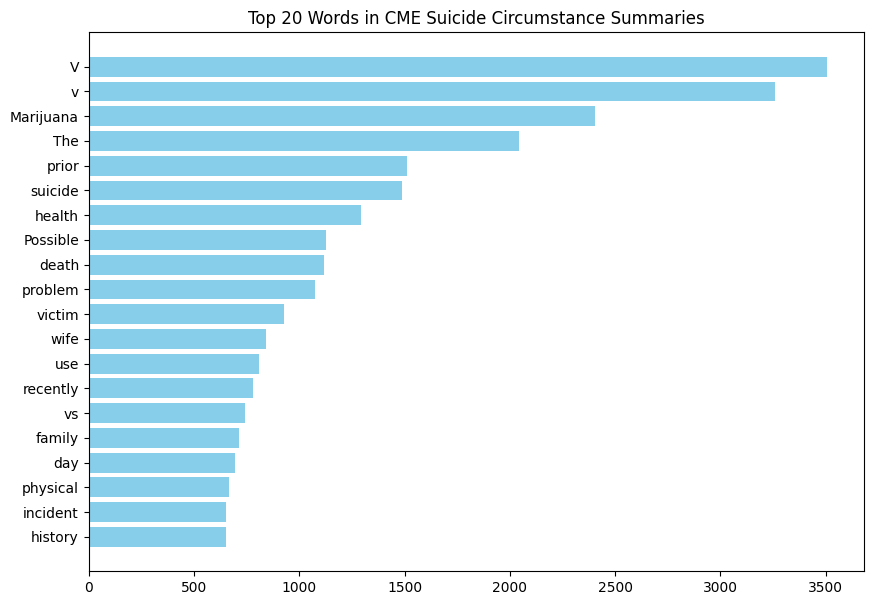

<Figure size 640x480 with 0 Axes>

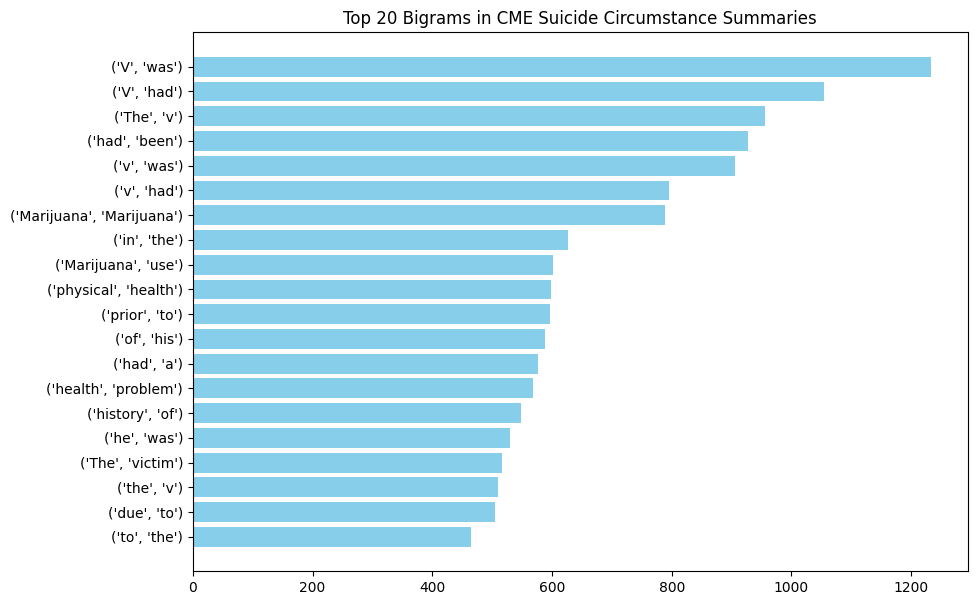

<Figure size 640x480 with 0 Axes>

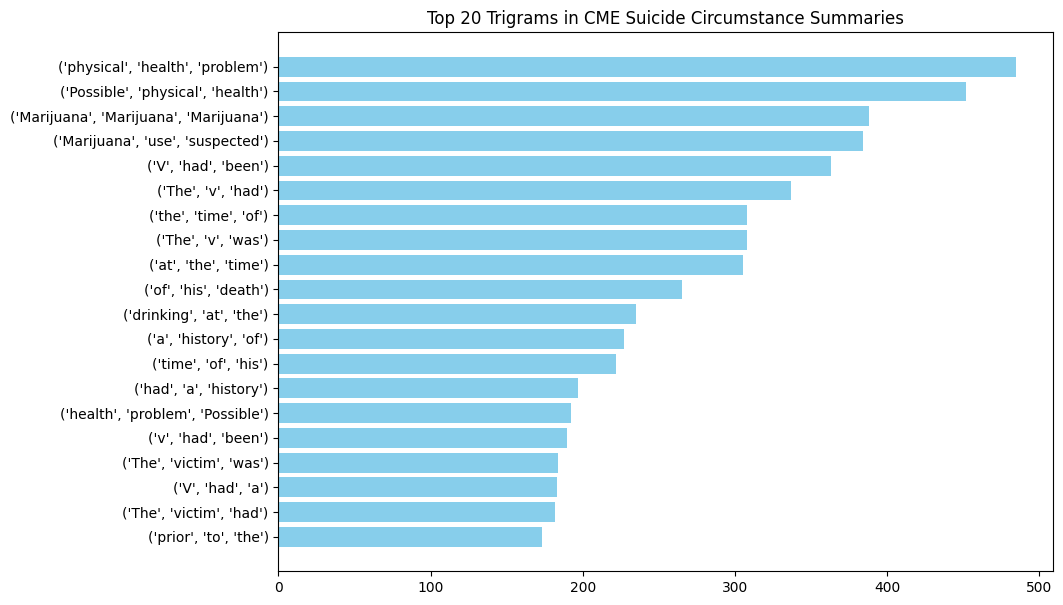

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string
import re

# Load the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re

#preprocess-- filter Na

# Remove rows where 'CME_CircumstancesOtherText' is NaN
nvdrs_non_na = nvdrs_raw.dropna(subset=['CME_CircumstancesOtherText'])

# If you specifically want to remove rows with the value "Na", you can use:
nvdrs_non_na_2 = nvdrs_non_na[~nvdrs_non_na['CME_CircumstancesOtherText'].isin(['Na', 'Na ',' Na', 'N/a'])]


# Filter rows where 'CME_CircumstancesOtherText' contains the word "Na"
na_df = nvdrs_non_na_2[nvdrs_non_na_2['CME_CircumstancesOtherText'].str.contains(r'\bNa\b', case=True, na=False)]
na_df['CME_CircumstancesOtherText']

def preprocess(sentence):
    # Check if the sentence is a string
    if not isinstance(sentence, str):
        return []

    # Remove punctuation from the sentence
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    tokens = sentence.split()
    return tokens



# Apply preprocessing and tokenization
na_df['Tokenized'] = na_df.apply(lambda row: preprocess(row['CME_CircumstancesOtherText']), axis=1)

# Flatten the list of words in Tokenized column
words = [word for sublist in na_df['Tokenized'].tolist() for word in sublist]

# Remove stopwords
filtered_words = [word for word in words if word not in stop_words]

# Generate bigrams and trigrams
bigram_list = list(bigrams(words))
trigram_list = list(trigrams(words))

# Get the frequency of each word, bigram, and trigram
filtered_word_freq = Counter(filtered_words)
bigram_freq = Counter(bigram_list)
trigram_freq = Counter(trigram_list)

# Get top 20 most common words, bigrams, and trigrams
top20_filtered_words = filtered_word_freq.most_common(20)
top20_bigrams = bigram_freq.most_common(20)
top20_trigrams = trigram_freq.most_common(20)

# Function to create count horizontal bar chat
def plot_most_common(n_most_common, title):
    items, counts = zip(*n_most_common)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(items)), counts, color='skyblue')
    plt.yticks(range(len(items)), items)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    plt.savefig(title + ".png", bbox_inches='tight', dpi=300)

# Plot top 20 most common words, bigrams, and trigrams
plot_most_common(top20_filtered_words, 'Top 20 Words in CME Suicide Circumstance Summaries')
plot_most_common(top20_bigrams, 'Top 20 Bigrams in CME Suicide Circumstance Summaries')
plot_most_common(top20_trigrams, 'Top 20 Trigrams in CME Suicide Circumstance Summaries')



# Topic Modeling

On LE_CircumstancesOtherText and CME_CircumstancesOtherText

## Resources:

https://www.theanalyticslab.nl/topic-modeling-with-bertopic/

https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#pre-calculate-embeddings

In [ ]:
## REad in combined dataset

# "CME_CircumstancesOtherText" , "LE_CircumstancesOtherText" , "CircumstancesKnown_c"
# in the NVDRS dataset.
# The output is a list of topics, each with a corresponding probability.

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from bertopic.vectorizers import ClassTfidfTransformer
import gensim.corpora as corpora
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string



def substance_type_topic_modeling(substance_regex_results, min_cluster_size, n_neighbors, n_components, min_distance):
    # Modifying filenames to include the new parameters:
    base_filename = f"{min_cluster_size}_cluster_size_{n_neighbors}_n_neighbors_{n_components}_n_components_{min_distance}_min_distance"
    filtered_df = substance_regex_results[substance_regex_results["CircumstancesKnown_c"] == "Yes"].copy()
    docs = filtered_df["CME_CircumstancesOtherText"].copy()
    print("There are a total of" , len(docs), "Circumstance Summaries, of", filtered_df["IncidentID"].nunique(), "decedents")
    docs = [str(x) for x in docs]

    seed_topic_list = [["isolation social" "isolation","social isolation","lonely","recluse", "loneliness","alone"],
                   ["homeless","evicted","housing","nowhere","homelessness","kicked out","housing instability", "no place",  "place to"],
                   ["veteran", "va treatment", "va", "war", "military", "iraq","vietnam","Vietnam","vet","Awol","navy","army","Navy","Army","Marine","marines"],
                       ["gender","identity","lgbt","transgender","gender identity", "gay","lesbian"]]

    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(docs, show_progress_bar=True)
    # Dimensionality reduction
    # Should we add n_neighbors, n_components, min_dist to function for grid search?
    umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_distance, metric='cosine')
    # Controlling for cluster size rather than n topics has been described as best practice for Bertopic bc nr_topics merges topics after they have been created, which supports creating fixed number.
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    # Vectorizer model can include bigrams also
    vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

    ctfidf_model = ClassTfidfTransformer()
    topic_model = BERTopic(embedding_model=embedding_model,
                           vectorizer_model=vectorizer_model,
                           umap_model=umap_model,
                           hdbscan_model=hdbscan_model,
                           ctfidf_model=ctfidf_model,
                           seed_topic_list=seed_topic_list).fit(docs, embeddings)
    topics, probs = topic_model.fit_transform(docs, embeddings)
    print(topic_model.get_topic_info())
    # Visualizations
    #Nice doc/topic representation
    doc_topic_vis = topic_model.visualize_documents(docs,embeddings = embeddings)
    doc_topic_vis.write_html(base_filename + "_doc_topic_vis.html")

    #topic distance
    topic_vis = topic_model.visualize_topics()
    topic_vis.write_html(base_filename + "_topic_vis.html")

    # Print topics and their most important words
    # Evaluation
    documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics})
    documents.to_csv(base_filename + "_docs_with_topics.csv")
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2)).fit(docs)
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)]
                   for topic in range(len(set(topics))-1)]
    topic_words_ids = []
    for topic in topic_words:
      topic_ids = []
      for word in topic:
        if word in dictionary.token2id:
            topic_ids.append(dictionary.token2id[word])
    topic_words_ids.append(topic_ids)
    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words_ids,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
    coherence = coherence_model.get_coherence()
    print(f"The Coherence of model with {min_cluster_size} cluster size, {n_neighbors} n_neighbors, {n_components} n_components, and {min_distance} min_distance is ", coherence)
    return min_cluster_size, n_neighbors, n_components, min_distance, coherence


import pandas as pd
import matplotlib.pyplot as plt

# Define your range start, stop, and step values
start = 55
stop = 65
step = 1

coherence_df = pd.DataFrame(columns=["min_cluster_size", "n_neighbors", "n_components", "min_distance", "coherence"])

# Grid search loops
for min_cluster_size in range(start, stop, step):
    for n_neighbors in range(15,16):
        for n_components in range(3, 4):
            for min_distance in [0.0, 0.1, 0.01]:
                results = substance_type_topic_modeling(nvdrs_raw, min_cluster_size, n_neighbors, n_components, min_distance)
                coherence_df = coherence_df.append({"min_cluster_size": results[0],
                                                    "n_neighbors": results[1],
                                                    "n_components": results[2],
                                                    "min_distance": results[3],
                                                    "coherence": results[4]},
                                                   ignore_index=True)


import plotly.express as px

# Sorting the dataframe by coherence and taking the top 10
top_10_coherence = coherence_df.sort_values(by='coherence', ascending=False).head(10)

# Using plotly express to plot the data
fig = px.scatter(top_10_coherence,
                 x="min_cluster_size",
                 y="coherence",
                 hover_data=["n_neighbors", "n_components", "min_distance"],
                 title="Top 10 Coherence by Min Cluster Size",
                 labels={"min_cluster_size": "Min Cluster Size", "coherence": "Coherence"})

# Save the figure to an HTML file (you can convert it to PNG later if you want)
filename = f"coherence_by_min_cluster_size_{start}_to_{stop-1}.html"
fig.write_html(filename)

# Show the interactive plot
fig.show()




In [ ]:
# Read in predictions from best peformer

topic_labels_df = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/57_cluster_size_15_n_neighbors_3_n_components_0.01_min_distance_docs_with_topics.csv")

topic_labels_df_social_isolation = topic_labels_df[topic_labels_df["Topic"].isin([2, 48])]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


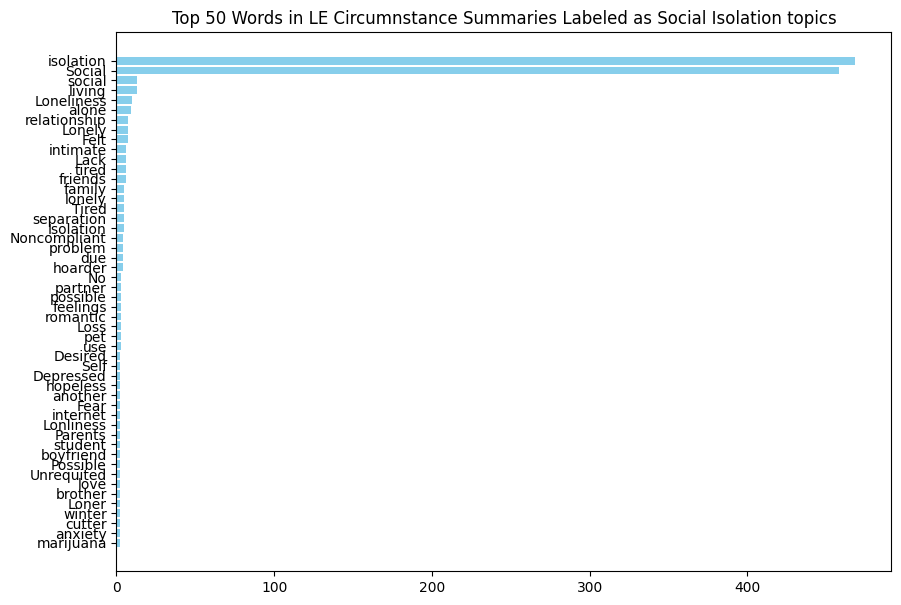

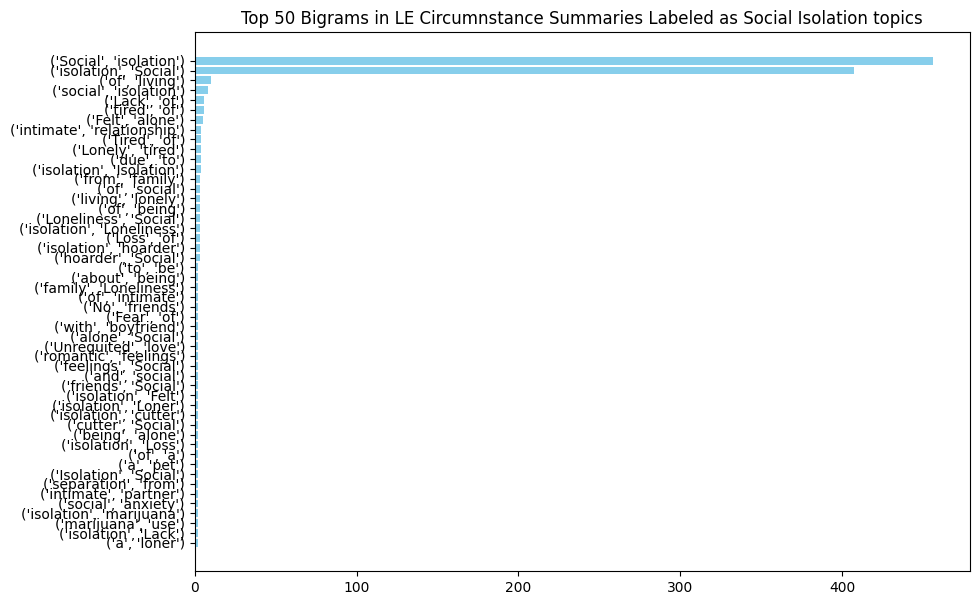

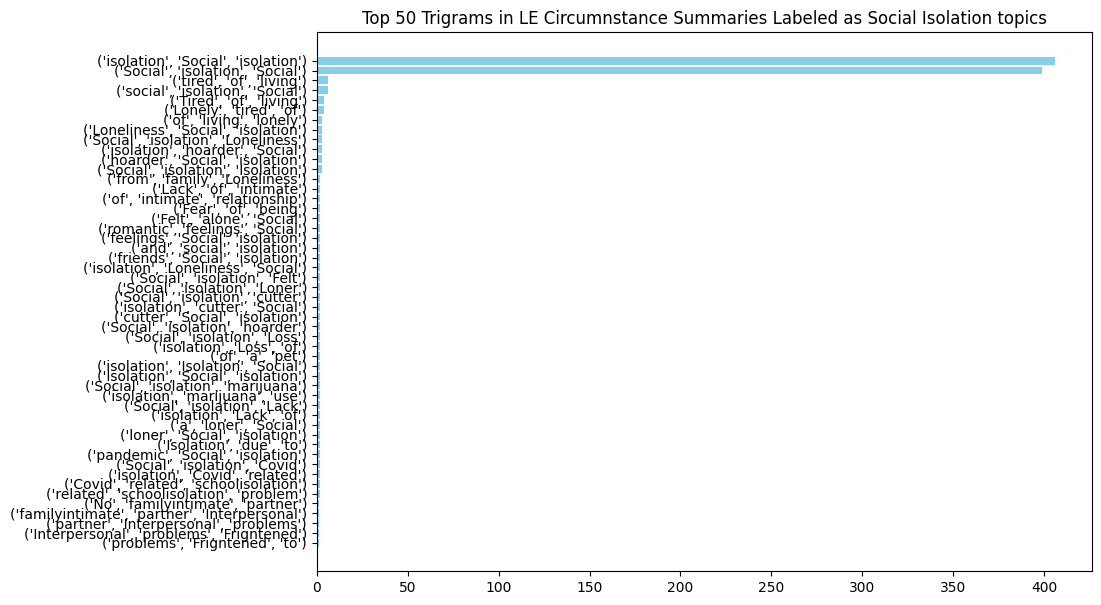

In [ ]:
# Top words, bi grams, trigrams from this as counter , as dataframe
import pandas as pd
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string
import re

# Load the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
def preprocess(sentence):
    # Check if the sentence is a string
    if not isinstance(sentence, str):
        return []

    # Remove punctuation from the sentence
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    tokens = sentence.split()
    return tokens


# Remove rows with empty 'Tokenized' lists


# Apply preprocessing and tokenization
topic_labels_df_social_isolation['Tokenized'] = topic_labels_df_social_isolation.apply(lambda row: preprocess(row['Document']), axis=1)


# Flatten the list of words in Tokenized column
words = [word for sublist in topic_labels_df_social_isolation['Tokenized'].tolist() for word in sublist]

# Remove stopwords
filtered_words = [word for word in words if word not in stop_words]

# Generate bigrams and trigrams
bigram_list = list(bigrams(words))
trigram_list = list(trigrams(words))

# Get the frequency of each word, bigram, and trigram
filtered_word_freq = Counter(filtered_words)
bigram_freq = Counter(bigram_list)
trigram_freq = Counter(trigram_list)

# Get top 30 most common words, bigrams, and trigrams
top50_filtered_words = filtered_word_freq.most_common(50)
top50_bigrams = bigram_freq.most_common(50)
top50_trigrams = trigram_freq.most_common(50)

# Function to create count horizontal bar chat
def plot_most_common(n_most_common, title):
    items, counts = zip(*n_most_common)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(items)), counts, color='skyblue')
    plt.yticks(range(len(items)), items)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    plt.show()

# Plot top 30 most common words, bigrams, and trigrams
plot_most_common(top50_filtered_words, 'Top 50 Words in LE Circumnstance Summaries Labeled as Social Isolation topics')
plot_most_common(top50_bigrams, 'Top 50 Bigrams in LE Circumnstance Summaries Labeled as Social Isolation topics')
plot_most_common(top50_trigrams, 'Top 50 Trigrams in LE Circumnstance Summaries Labeled as Social Isolation topics')


# make counter df
matched_term_freq_df = pd.DataFrame(dict(top50_filtered_words).items(), columns=['word', 'frequency'])
matched_term_freq_df['social_isolation_relevant'] = ""


# Convert the Counter for bigrams into a dataframe
matched_bigram_freq_df = pd.DataFrame(dict(top50_bigrams).items(), columns=['bigram', 'frequency'])
matched_bigram_freq_df['social_isolation_relevant'] = ""

# Convert the Counter for trigrams into a dataframe
matched_trigram_freq_df = pd.DataFrame(dict(top50_trigrams).items(), columns=['trigram', 'frequency'])
matched_trigram_freq_df['social_isolation_relevant'] = ""

# Save them to CSV
matched_term_freq_df.to_csv("social_isolation_topic_top_50_words.csv")
matched_bigram_freq_df.to_csv("social_isolation_topic_top_50_bigrams.csv")
matched_trigram_freq_df.to_csv("social_isolation_topic_top_50_trigrams.csv")




# Pruned words, bigrams, trigrams regex search for social isolation (Chronic)

In [ ]:
import pandas as pd

# Read the CSV files
pruned_social_isolation_words = pd.read_csv("social_isolation_topic_top_50_words_adjudicated.csv")
pruned_social_isolation_bigrams = pd.read_csv("social_isolation_topic_top_50_bigrams_adjudicated.csv")
pruned_social_isolation_trigrams = pd.read_csv("social_isolation_topic_top_50_trigrams_adjudicated.csv")

# Filter relevant words/bigrams/trigrams
word_list = pruned_social_isolation_words[pruned_social_isolation_words['social_isolation_relevant'] == 1]['word'].tolist()

# Clean up the bigrams by removing the tuple syntax and extra characters
bigram_list = [bigram.strip("()").replace("'", "").replace(",", "") for bigram in pruned_social_isolation_bigrams[pruned_social_isolation_bigrams['social_isolation_relevant'] == 1]['bigram'].tolist()]

# Clean up the trigrams similarly
trigram_list = [trigram.strip("()").replace("'", "").replace(",", "") for trigram in pruned_social_isolation_trigrams[pruned_social_isolation_trigrams['social_isolation_relevant'] == 1]['trigram'].tolist()]

# Create the regex patterns
unigram_pattern = r'\b(?:' + '|'.join(word_list) + r')\b'
bigram_pattern = r'\b(?:' + '|'.join(bigram_list) + r')\b'
trigram_pattern = r'\b(?:' + '|'.join(trigram_list) + r')\b'

# Combine the patterns using the pipe symbol (|) to denote OR
combined_pattern = unigram_pattern + "|" + bigram_pattern + "|" + trigram_pattern





# Regex search social isolation (chronic)

In [ ]:
def remove_illegal_characters(df):
    for col in df.columns:
        if df[col].dtype == object:  # Only apply to columns with datatype 'object' (string columns)
            df[col] = df[col].apply(lambda x: ILLEGAL_CHARACTERS_RE.sub("", x) if isinstance(x, str) else x)
    return df

def extract_matches(matches):
    # Flatten the list of tuples and filter out empty matches
    return [match for match in matches if match]
# Compile regex for efficiency
compiled_pattern = re.compile(combined_pattern, re.VERBOSE)


# Apply regex operations to rows where `NarrativeCME` is not NaN
mask = nvdrs_raw['NarrativeCME'].notna()
nvdrs_raw.loc[mask, 'matched_term'] = nvdrs_raw.loc[mask, 'NarrativeCME'].str.findall(combined_pattern).apply(extract_matches)

# Filter to include only rows with non-empty 'matched_term'
filtered_nvdrs_df = nvdrs_raw[mask & nvdrs_raw['matched_term'].map(bool)]


# Remove illegal characters, filter rows, and save to Excel for `NarrativeCME`
filtered_nvdrs_df_cme = filtered_nvdrs_df[mask][['IncidentID', 'NarrativeCME', 'matched_term', 'CME_CircumstancesOtherText']]
filtered_nvdrs_df_cme = remove_illegal_characters(filtered_nvdrs_df_cme)
filtered_nvdrs_df_cme.to_excel("social_isolation_regex_cme.xlsx", index=False)

# Apply regex operations to `NarrativeLE`
mask = nvdrs_raw['NarrativeLE'].notna()
nvdrs_raw.loc[mask, 'matched_term'] = nvdrs_raw.loc[mask, 'NarrativeLE'].str.findall(combined_pattern).apply(extract_matches)
# Filter to include only rows with non-empty 'matched_term'
filtered_nvdrs_df = nvdrs_raw[mask & nvdrs_raw['matched_term'].map(bool)]

# Remove illegal characters, filter rows, and save to Excel for `NarrativeLE`
filtered_nvdrs_df_le = filtered_nvdrs_df[['IncidentID', 'NarrativeLE', 'matched_term', 'LE_CircumstancesOtherText']]
filtered_nvdrs_df_le = remove_illegal_characters(filtered_nvdrs_df_le)
filtered_nvdrs_df_le.to_excel("social_isolation_regex_le.xlsx", index=False)




In [ ]:
print(filtered_nvdrs_df["NarrativeLE"][0:10])

# CME and LE Narrative Social Isolation Matches

In [ ]:
cme_narrative_social_isolation_matches = pd.read_excel("social_isolation_regex_cme.xlsx")

le_narrative_social_isolation_matches = pd.read_excel("social_isolation_regex_le.xlsx")
# Combined, all social isolation posts ~2015
full = le_narrative_social_isolation_matches.merge(cme_narrative_social_isolation_matches, on='IncidentID', how='outer')
full['topic_name'] = 'social_isolation'

# Annotation sampling


In [ ]:
# Assuming you already have the 'full' and 'nvdrs_raw' dataframes defined.
# If not, you'll need to load them or create them.

# Step 1: Modify and save the 'full' dataframe
full = full[['IncidentID', 'NarrativeCME','matched_term_y','CME_CircumstancesOtherText','NarrativeLE','matched_term_x','LE_CircumstancesOtherText','topic_name']]
full.to_excel("social_isolation_full_dataframe.xlsx", index=False)

def sample_and_save(df, topic_name):
    # Make sure to only sample if there are enough rows
    if len(df) >= 50:
        sampled_df = df.sample(n=50, random_state=1)  # use a fixed seed for reproducibility if necessary
    else:
        sampled_df = df  # If less than 50, take all
    # Add a new column with blank values
    sampled_df['topic_relevant_annotation'] = ''

    # Save the dataframe to a CSV file
    sampled_df.to_csv(f"{topic_name}_sampled.csv", index=False)
sample_and_save(full,"social_isolation_chronic")


## NA EDA

In [ ]:
import pandas as pd

variables = ['NarrativeCME', 'NarrativeLE', 'LE_CircumstancesOtherText', 'CME_CircumstancesOtherText']
na_strings = ['Na', 'Na ', ' Na', 'N/a']

def count_na_like_values(column):
    # Count actual NA values
    na_count = column.isna().sum()

    # Add counts of the custom strings
    for na_str in na_strings:
        na_count += column.str.contains(na_str, case=False, na=False).sum()

    non_na_count = len(column) - na_count
    avg_str_length = column.str.len().dropna().mean()  # dropna to avoid NaN in mean calculation

    return na_count, non_na_count, avg_str_length

results = {variable: count_na_like_values(nvdrs_raw[variable]) for variable in variables}

# Print the results
for variable, (na_count, non_na_count, avg_str_length) in results.items():
    print(f"{variable}:")
    print(f"\tNA-like values: {na_count}")
    print(f"\tNon-NA values: {non_na_count}")
    print(f"\tAverage string length (excluding NAs): {avg_str_length:.2f} characters\n")

# If you'd like to convert this dictionary to a DataFrame for nicer formatting:
df_results = pd.DataFrame([(var, res[0], res[1], res[2]) for var, res in results.items()],
                          columns=["Variable", "NA-like Count", "Non-NA Count", "Avg String Length"])
print(df_results)


NarrativeCME:
	NA-like values: 173069
	Non-NA values: 133470
	Average string length (excluding NAs): 663.03 characters

NarrativeLE:
	NA-like values: 180593
	Non-NA values: 125946
	Average string length (excluding NAs): 704.88 characters

LE_CircumstancesOtherText:
	NA-like values: 289987
	Non-NA values: 16552
	Average string length (excluding NAs): 48.01 characters

CME_CircumstancesOtherText:
	NA-like values: 286115
	Non-NA values: 20424
	Average string length (excluding NAs): 40.25 characters

                     Variable  NA-like Count  Non-NA Count  Avg String Length
0                NarrativeCME         173069        133470         663.027011
1                 NarrativeLE         180593        125946         704.875156
2   LE_CircumstancesOtherText         289987         16552          48.009709
3  CME_CircumstancesOtherText         286115         20424          40.247291


In [ ]:
import pandas as pd

# Placeholder data for demonstration
# nvdrs_raw = pd.DataFrame({
#     'NarrativeCME': ['Na', 'Sample Text', 'Another Sample', 'Na '],
#     'NarrativeLE': [None, 'Na', 'Good Text', 'Na '],
# })

na_strings = ['Na', 'Na ', ' Na', 'N/a']

def is_na_like(column):
    # Create a boolean mask for actual NA values
    mask = column.isna()

    # Update the mask for custom strings
    for na_str in na_strings:
        mask |= column.str.contains(na_str, case=False, na=False)

    return mask

# Calculate rows with NA-like values for both columns
both_na_rows = is_na_like(nvdrs_raw['NarrativeCME']) & is_na_like(nvdrs_raw['NarrativeLE'])

count_both_na = both_na_rows.sum()

print(f"{count_both_na} rows have NA or NA-like values for both 'NarrativeCME' and 'NarrativeLE'.")

total_rows = len(nvdrs_raw)
count_non_na = total_rows - count_both_na

print(f"{count_non_na} rows have non-NA values for both 'NarrativeCME' and 'NarrativeLE'.")


90302 rows have NA or NA-like values for both 'NarrativeCME' and 'NarrativeLE'.
216237 rows have non-NA values for both 'NarrativeCME' and 'NarrativeLE'.


# Social isolation events topics

In [ ]:
# Read in predictions from best peformer

topic_labels_df_events = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/55_cluster_size_15_n_neighbors_3_n_components_0.01_min_distance_docs_with_topics.csv")

topic_labels_df_social_isolation_events = topic_labels_df_events[topic_labels_df_events["Topic"].isin([10, 14,52,62])]



Topics are:

*   10 dog_victim_dog_pet
*   14 custody_children_child
*   52 break_girlfriend_recent_break
*   62 divorce_papers_divorce papers
*   53 job loss
*   7 eviction/moving



# Process Topic Function

Takes topic number, reads in all circumstances, creates initial top word, bigram, trigram lists which will be adjudicated in the next step

*   10 dog_victim_dog_pet
*   14 custody_children_child
*   52 break_girlfriend_recent_break
*   62 divorce_papers_divorce papers


In [ ]:
import pandas as pd
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string
import re

def process_topic(topic_number):

    # Map topic numbers to topic names
    topic_name_map = {10: "pet", 14: "child", 52: "breakup", 62: "divorce", 53: "job loss", 7:"eviction or move"}

    # Check if topic number is valid
    if topic_number not in topic_name_map:
        print("Invalid topic number.")
        return

    topic_name = topic_name_map[topic_number]

    # Read in predictions from best performer
    topic_labels_df_events = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/55_cluster_size_15_n_neighbors_3_n_components_0.01_min_distance_docs_with_topics.csv")

    topic_labels_df_selected = topic_labels_df_events[topic_labels_df_events["Topic"] == topic_number]

    # Load the stopwords
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    def preprocess(sentence):
        # Check if the sentence is a string
        if not isinstance(sentence, str):
            return []

        # Remove punctuation from the sentence
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        tokens = sentence.split()
        return tokens

    # Apply preprocessing and tokenization
    topic_labels_df_selected['Tokenized'] = topic_labels_df_selected.apply(lambda row: preprocess(row['Document']), axis=1)

    # Flatten the list of words in Tokenized column
    words = [word for sublist in topic_labels_df_selected['Tokenized'].tolist() for word in sublist]

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Generate bigrams and trigrams
    bigram_list = list(bigrams(words))
    trigram_list = list(trigrams(words))

    # Get the frequency of each word, bigram, and trigram
    filtered_word_freq = Counter(filtered_words)
    bigram_freq = Counter(bigram_list)
    trigram_freq = Counter(trigram_list)

    # Get top 50 most common words, bigrams, and trigrams
    top50_filtered_words = filtered_word_freq.most_common(50)
    top50_bigrams = bigram_freq.most_common(50)
    top50_trigrams = trigram_freq.most_common(50)

    # Function to create count horizontal bar chat
    def plot_most_common(n_most_common, title):
        items, counts = zip(*n_most_common)
        plt.figure(figsize=(10, 7))
        plt.barh(range(len(items)), counts, color='skyblue')
        plt.yticks(range(len(items)), items)
        plt.gca().invert_yaxis()
        plt.title(title)
        plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
        plt.show()

    # Plot top 50 most common words, bigrams, and trigrams
    plot_most_common(top50_filtered_words, f'Top 50 Words in LE Circumstance Summaries Labeled as {topic_name}')
    plot_most_common(top50_bigrams, f'Top 50 Bigrams in LE Circumstance Summaries Labeled as {topic_name}')
    plot_most_common(top50_trigrams, f'Top 50 Trigrams in LE Circumstance Summaries Labeled as {topic_name}')

    # Make counter df
    matched_term_freq_df = pd.DataFrame(dict(top50_filtered_words).items(), columns=['word', 'frequency'])
    matched_term_freq_df['social_isolation_relevant'] = ""

    # Convert the Counter for bigrams into a dataframe
    matched_bigram_freq_df = pd.DataFrame(dict(top50_bigrams).items(), columns=['bigram', 'frequency'])
    matched_bigram_freq_df['social_isolation_relevant'] = ""

    # Convert the Counter for trigrams into a dataframe
    matched_trigram_freq_df = pd.DataFrame(dict(top50_trigrams).items(), columns=['trigram', 'frequency'])
    matched_trigram_freq_df['social_isolation_relevant'] = ""

    # Save them to CSV
    matched_term_freq_df.to_csv(f"{topic_name}_topic_top_50_words.csv")
    matched_bigram_freq_df.to_csv(f"{topic_name}_topic_top_50_bigrams.csv")
    matched_trigram_freq_df.to_csv(f"{topic_name}_topic_top_50_trigrams.csv")

# Example usage:
process_topic(10)  # For 'pet'
process_topic(14) # for 'child'
process_topic(52) # breakup
process_topic(62) # divorce
process_topic(53) # job loss
process_topic(7) # eviction or move


Output hidden; open in https://colab.research.google.com to view.

# Concatenate all social isolation and social isolation event topic dataframes

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2)
ILLEGAL_CHARACTERS_RE = re.compile(r'[\000-\010]|[\013-\014]|[\016-\037]')
# Test # topic_name_dict = {10: "pet"}
topic_name_dict = {10: "pet", 14: "child", 52: "breakup", 62: "divorce", 53: "job loss", 7:"eviction or move"}

def process_narrative(column_name, combined_pattern_events):
    mask = nvdrs_raw[column_name].notna()
    # Find all matches and apply extract_matches function
    nvdrs_raw.loc[mask, 'matched_term'] = nvdrs_raw.loc[mask, column_name].str.findall(combined_pattern_events).apply(lambda matches: [match for match in matches if match])
    # Filter the DataFrame to only include rows where 'matched_term' is not empty
    filtered_nvdrs_df = nvdrs_raw[mask & nvdrs_raw['matched_term'].map(bool)]
    # If needed, remove illegal characters
    if column_name == 'NarrativeLE':
        filtered_nvdrs_df[column_name] = filtered_nvdrs_df[column_name].str.replace(ILLEGAL_CHARACTERS_RE, "", regex=True)
    return filtered_nvdrs_df[['IncidentID', column_name, 'matched_term', f'{column_name.split("Narrative")[1]}_CircumstancesOtherText']]

def regex_topic(Topic):
    topic_name = topic_name_dict[Topic]
    file_prefix = topic_name + "_"

    # Read the CSV files
    pruned_social_isolation_words = pd.read_csv(file_prefix + "topic_top_50_words_adjudicated.csv")
    pruned_social_isolation_bigrams = pd.read_csv(file_prefix + "topic_top_50_bigrams_adjudicated.csv")
    pruned_social_isolation_trigrams = pd.read_csv(file_prefix + "topic_top_50_trigrams_adjudicated.csv")

    # Filter relevant words/bigrams/trigrams
    word_list = pruned_social_isolation_words[pruned_social_isolation_words['social_isolation_relevant'] == 1]['word'].tolist()

    # Clean up the bigrams by removing the tuple syntax and extra characters
    bigram_list = [bigram.strip("()").replace("'", "").replace(",", "") for bigram in pruned_social_isolation_bigrams[pruned_social_isolation_bigrams['social_isolation_relevant'] == 1]['bigram'].tolist()]

    # Clean up the trigrams similarly
    trigram_list = [trigram.strip("()").replace("'", "").replace(",", "") for trigram in pruned_social_isolation_trigrams[pruned_social_isolation_trigrams['social_isolation_relevant'] == 1]['trigram'].tolist()]

    # Create the regex patterns
    unigram_pattern = r'\b(?:' + '|'.join(word_list) + r')\b'
    bigram_pattern = r'\b(?:' + '|'.join(bigram_list) + r')\b'
    trigram_pattern = r'\b(?:' + '|'.join(trigram_list) + r')\b'

    # Combine the patterns using the pipe symbol (|) to denote OR
    combined_pattern_events = unigram_pattern + "|" + bigram_pattern + "|" + trigram_pattern
    # process and search thru cme and le narratives
    cme_df = process_narrative('NarrativeCME', combined_pattern_events)
    le_df = process_narrative('NarrativeLE', combined_pattern_events)

    merged_df = le_df.merge(cme_df, on='IncidentID', how='outer')
    merged_df['topic_name'] = topic_name  # add the topic name

    return merged_df
def sample_and_save(df, topic_name):
    # Make sure to only sample if there are enough rows
    if len(df) >= 50:
        sampled_df = df.sample(n=50, random_state=1)  # use a fixed seed for reproducibility if necessary
    else:
        sampled_df = df  # If less than 50, take all
    # Add a new column with blank values
    sampled_df['topic_relevant_annotation'] = ''

    # Save the dataframe to a CSV file
    sampled_df.to_csv(f"{topic_name}_sampled.csv", index=False)


# Pre-compile regex for illegal characters
ILLEGAL_CHARACTERS_RE = re.compile(r'[\000-\010]|[\013-\014]|[\016-\037]')

def remove_illegal_characters(df):
    for col in df.columns:
        if df[col].dtype == object:  # Only apply to columns with datatype 'object' (string columns)
            df[col] = df[col].apply(lambda x: ILLEGAL_CHARACTERS_RE.sub("", x) if isinstance(x, str) else x)
    return df

# Initialize the all_topic_data list
all_topic_data = []

# Process each topic and append the resulting DataFrame to all_topic_data
for topic in topic_name_dict.keys():
    topic_df = regex_topic(topic)
    all_topic_data.append(topic_df)

# Now all_topic_data is defined and can be used in the loop below
# Process each topic, remove illegal characters, sample, and save to CSV files
for topic, df in zip(topic_name_dict.keys(), all_topic_data):
    topic_name = topic_name_dict[topic]
    df_cleaned = remove_illegal_characters(df)
    sample_and_save(df_cleaned, topic_name)

import ast
# Define a function to convert string representations of lists into actual lists
def convert_to_list(value):
    if isinstance(value, list):
        return value
    elif isinstance(value, str) and value.strip() != '':
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return [value]
    return []

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_matched_terms(df, topic_name):
    # Ensure 'matched_term_x' and 'matched_term_y' are lists and not strings
    df['matched_term_x'] = df['matched_term_x'].apply(convert_to_list)
    df['matched_term_y'] = df['matched_term_y'].apply(convert_to_list)

    # Combine 'matched_term_x' and 'matched_term_y' into a single list without duplicates within the same row
    combined_terms = []
    for x, y in zip(df['matched_term_x'], df['matched_term_y']):
        combined_terms.append(list(set(x) | set(y)))

    df['matched_terms_combined'] = combined_terms

    # Flatten the list of matched terms for each row and count occurrences
    all_terms = df.explode('matched_terms_combined')['matched_terms_combined']
    term_counts = all_terms.value_counts().head(20)  # Get the top 20 terms

    # Check if there are terms to plot
    if term_counts.empty:
        print(f"No data to plot for topic: {topic_name}")
        return

    # Create the plot if there is data
    plt.figure(figsize=(12, 8))
    sns.barplot(x=term_counts.values, y=term_counts.index, palette='tab10')

    # Set the title and labels
    plt.title(f'Top 20 Matched Terms for Topic: {topic_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Matched Terms')

    # Save the plot to a PNG file
    plt.tight_layout()
    plt.savefig(f"{topic_name}_top_matched_terms.png", dpi=300)

# Assuming 'all_topic_data' is a list of DataFrames, where each DataFrame corresponds to a topic
for topic_df, (topic_id, topic_name) in zip(all_topic_data, topic_name_dict.items()):
    plot_top_matched_terms(topic_df, topic_name)


# Concatenate all DataFrames in all_topic_data into a single DataFrame
final_data = pd.concat(all_topic_data, ignore_index=True)

# Load the social_isolation_full_dataframe, remove illegal characters, and append it to the final_data
social_isolation_df = pd.read_excel("social_isolation_full_dataframe.xlsx")
social_isolation_df_cleaned = remove_illegal_characters(social_isolation_df)
final_combined_data = pd.concat([final_data, social_isolation_df_cleaned], ignore_index=True)

# Save the final combined data to an Excel file
final_combined_data.to_excel("final_combined_data.xlsx", index=False)

# Merge specific columns with final_combined_data, remove illegal characters, and save
merged_data = final_combined_data.merge(nvdrs_raw, on='IncidentID', how='left')
merged_data_cleaned = remove_illegal_characters(merged_data)
unique_incident_ids_count = merged_data_cleaned['IncidentID'].nunique()
print(f"Number of distinct IncidentID values: {unique_incident_ids_count}")

# Save the cleaned merged data to an Excel file
merged_data_cleaned.to_excel("final_merged_data.xlsx", index=False)




Number of distinct IncidentID values: 56947


# Final Dataset EDA/Models


In [ ]:
import pandas as pd
merged_data
# 1. Summarize nvdrs_raw by IncidentYear
nvdrs_summary = nvdrs_raw.groupby('IncidentYear').size().reset_index(name='total_count')

# 2. Summarize merged_data by IncidentYear and topic_name
merged_data_summary = merged_data.groupby(['IncidentYear', 'topic_name']).size().reset_index(name='topic_count')

# 3. Merge the two summary dataframes based on IncidentYear
merged_summary = pd.merge(merged_data_summary, nvdrs_summary, on='IncidentYear', how='left')

merged_summary['topic_percent'] = (merged_summary['topic_count']/merged_summary['total_count'])
# Keep the desired columns
final_summary = merged_summary[['topic_name', 'IncidentYear', 'topic_count', 'topic_percent', 'total_count']]

# Display or save the summary dataframe
print(final_summary)
# Optional: Save to an Excel file
# final_summary.to_excel("summary_data.xlsx", index=False)


           topic_name  IncidentYear  topic_count  topic_percent  total_count
0             breakup          2003          122       0.033683         3622
1               child          2003           36       0.009939         3622
2             divorce          2003          129       0.035616         3622
3    eviction or move          2003          170       0.046935         3622
4                 pet          2003            5       0.001380         3622
..                ...           ...          ...            ...          ...
103             child          2020          685       0.017688        38727
104           divorce          2020         1524       0.039352        38727
105  eviction or move          2020         3787       0.097787        38727
106               pet          2020          170       0.004390        38727
107  social_isolation          2020          216       0.005578        38727

[108 rows x 5 columns]


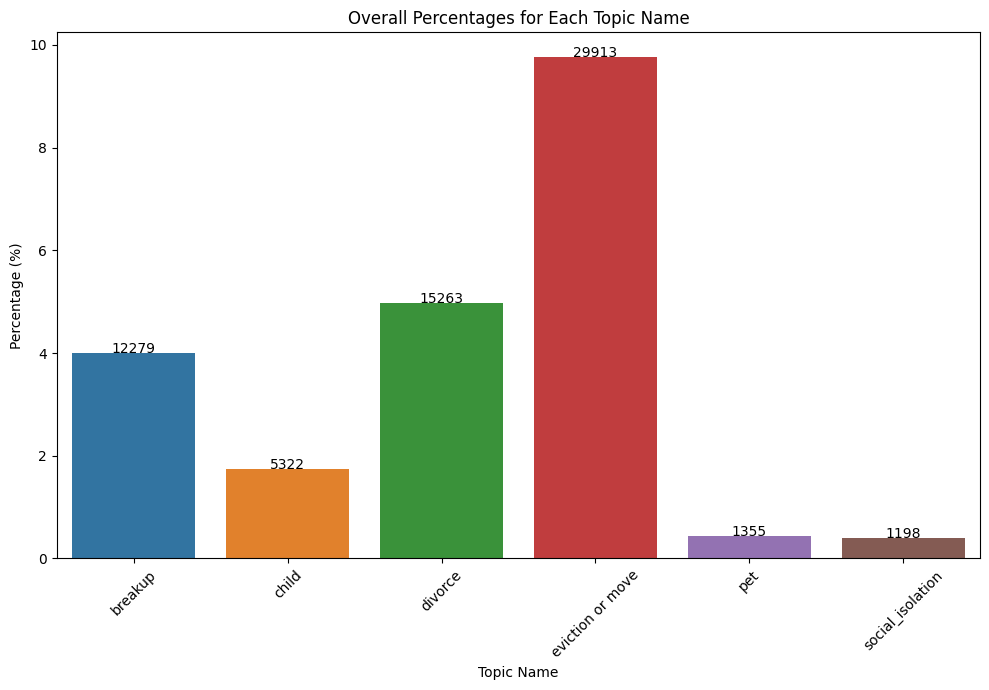

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'IncidentYear' is an integer if it's not already
final_summary['IncidentYear'] = final_summary['IncidentYear'].astype(int)

# Setting the style
sns.set_style("whitegrid")

# 1. Line Graph
plt.figure(figsize=(15, 8))
sns.lineplot(data=final_summary, x="IncidentYear", y="topic_percent", hue="topic_name", marker="o", palette="tab10")

plt.title("Percent of Narratives by Year for Each Topic")
plt.legend(title='Topic Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-ticks to be every year present in the 'IncidentYear' column
plt.xticks(final_summary['IncidentYear'].unique())

plt.tight_layout()
plt.savefig("Topic_percent_by_Year_for_Each_Topic.png", dpi=300)
plt.show()



# Bar graph totals
# 1. Compute total narratives
total_narratives = 306539

# 2. Compute percentages
overall_totals = final_summary.groupby('topic_name')['topic_count'].sum().reset_index()
overall_totals['percentage'] = (overall_totals['topic_count'] / total_narratives) * 100

# 3. Bar Graph
plt.figure(figsize=(10, 7))
bar_plot = sns.barplot(data=overall_totals, x="topic_name", y="percentage", palette="tab10")

# Add labels on top of the bars
for index, row in overall_totals.iterrows():
    bar_plot.text(index, row['percentage'], round(row['topic_count']), color='black', ha="center")

plt.title("Overall Percentages for Each Topic Name")
plt.xlabel("Topic Name")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Overall_Percentages_for_Each_Topic_Name.png", dpi=300)
plt.show()

# Grab new samples

In [ ]:
# Read in merged data
merged_data = pd.read_excel("final_merged_data.xlsx")

# Read in already completed annotations
breakup_set = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/round_1_annotation_topics/breakup_sampled_sd_completed.csv")
divorce_set = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/round_1_annotation_topics/divorce_sampled_sr_completed.csv")
eviction_set = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/round_1_annotation_topics/eviction or move_sampled_sp_completed.csv")
pet_set = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/round_1_annotation_topics/pet_sampled_dw_completed.csv")
social_isolation_chronic_set = pd.read_csv("/content/gdrive/MyDrive/nvdrs_narratives/round_1_annotation_topics/social_isolation_chronic_sampled_dw_completed.csv")

full_set = pd.concat([breakup_set, divorce_set, eviction_set, pet_set, social_isolation_chronic_set])

# Filter IncidentID not in already completed annotation incidentID list
filtered_data = merged_data[~merged_data['IncidentID'].isin(full_set['IncidentID'])]

import numpy as np
# Set random seed for reproducibility
np.random.seed(23)
# Clean merged variable names
# Wrong variables: NarrativeLE_x , LE_CircumstancesOtherText_x, NarrativeCME_x, CME_CircumstancesOtherText_x
# 'NarrativeCME', 'matched_term_y', 'CME_CircumstancesOtherText', 'NarrativeLE', 'matched_term_x', 'LE_CircumstancesOtherText'
filtered_data = filtered_data.rename(columns={"NarrativeLE_x": "NarrativeLE", "LE_CircumstancesOtherText_x": "LE_CircumstancesOtherText", "NarrativeCME_x": "NarrativeCME", "CME_CircumstancesOtherText_x":"CME_CircumstancesOtherText"})
# Define the columns to keep in the final dataframes
columns_to_keep = ['IncidentID', 'NarrativeCME', 'matched_term_y', 'CME_CircumstancesOtherText',
                   'NarrativeLE', 'matched_term_x', 'LE_CircumstancesOtherText', 'topic_name',
                   'topic_relevant_annotation', 'comments']

# Iterate over each unique topic in the topic_name column of filtered_data
for topic in filtered_data['topic_name'].unique():
    # Sample 9 increments of 50 rows without replacement for the current topic
    for i in range(9):
        sample_df = filtered_data[filtered_data['topic_name'] == topic].sample(n=50, replace=False)

        sample_df['topic_relevant_annotation'] = ''
        sample_df['comments'] = ''

        # Keep only the specified columns
        sample_df = sample_df[columns_to_keep]

        # Write to CSV file
        sample_df.to_csv(f'{topic}_sample_{i}.csv', index=False)

        # Remove the sampled rows from the filtered_data
        filtered_data = filtered_data.drop(sample_df.index)

